In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd

In [64]:
m1 = 1.006
m2 = 0.503
k1 = 230
k2 = 72
M = np.matrix([[m1, 0], [0, m2]])
K = np.matrix([[k1+k2, -k2], [-k2, k2]])

### Rensa datan av headers som orsakar massa problem i grafningen

In [28]:
from pathlib import Path
from sys import platform

# get all .tsv files in current directory
tsv_files = list(Path(".").glob("*.tsv"))
def clean_data(files, out_dir):  
    out_dir.mkdir(exist_ok=True)
    for file_path in files:
        out_path = out_dir / file_path.name
        print(f"Processing {file_path} → {out_path}")
    
        # read file as text and skip first 10 lines
        with file_path.open("r", encoding="utf-8") as infile:
            lines = infile.readlines()[11:]  # skip the first 10 lines
    
        # write the rest to the new file
        with out_path.open("w", encoding="utf-8") as outfile:
            outfile.writelines(lines)
clean_data(tsv_files, Path("data"))

Processing 1_f3.tsv → data/1_f3.tsv
Processing 2_f1.tsv → data/2_f1.tsv
Processing 2_f2.tsv → data/2_f2.tsv
Processing 4_f1.tsv → data/4_f1.tsv
Processing 1_f2_notgood.tsv → data/1_f2_notgood.tsv
Processing 3_f1.tsv → data/3_f1.tsv
Processing 5_f1.tsv → data/5_f1.tsv
Processing 1_f1.tsv → data/1_f1.tsv


In [58]:
file_path = list(Path("data").glob("1_f1.tsv"))
df = pd.read_csv(
    file_path[0], 
    sep='\t',
    header=None,
)

df.columns = ["x1", "y1", "z1", "x2", "y2", "z2"]

t = np.array(range(len(df)))
interval = range(1, len(t)-700)

z1_diff = df.z1 - np.mean(df.z1)
z2_diff = df.z2 - np.mean(df.z2)

In [50]:
# Define external forces f1(t), f2(t)
def f1(t): 
    return 0.0             # example: no forcing
def f2(t): 
    return 1.0*np.sin(2*t) # example: sinusoidal forcing

# ODE system
def deriv(t, X):
    x1, x2, x3, x4 = X
    dx1dt = x2
    dx2dt = (f1(t) + k2*(x3 - x1) - k1*x1) / m1
    dx3dt = x4
    dx4dt = (f2(t) - k2*(x3 - x1)) / m2
    return [dx1dt, dx2dt, dx3dt, dx4dt]

# Initial conditions
X0 = [0.0, 0.0, 0.0, 0.0]

# Time span
num_t_span = (0, 20)
num_t_eval = np.linspace(*t_span, len(t))

# Solve numerically
num_sol = solve_ivp(deriv, t_span, X0, t_eval=t_eval, rtol=1e-8, atol=1e-8)

# Extract solutions
num_t = num_sol.t
num_y1, y2 = num_sol.y[0], sol.y[2]

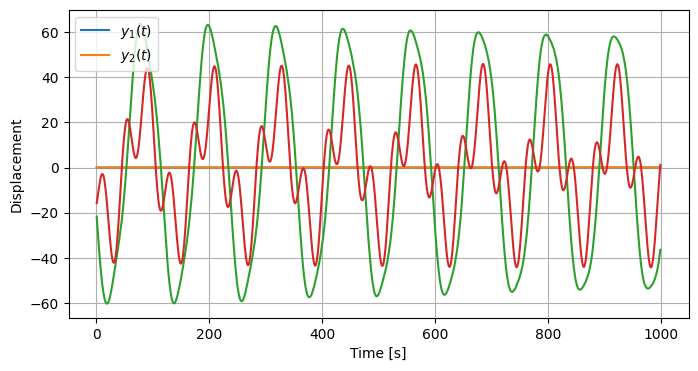

In [52]:
plt.figure(figsize=(8,4))
plt.plot(t[interval], y1[interval], label='Num $y_1(t)$')
plt.plot(t[interval], y2[interval], label='Num $y_2(t)$')
plt.xlabel('Time [s]')
plt.ylabel('Displacement')
plt.legend()
plt.grid(True)
plt.plot(t[interval], z1_diff[interval], )
plt.plot(t[interval], z2_diff[interval])
plt.show()

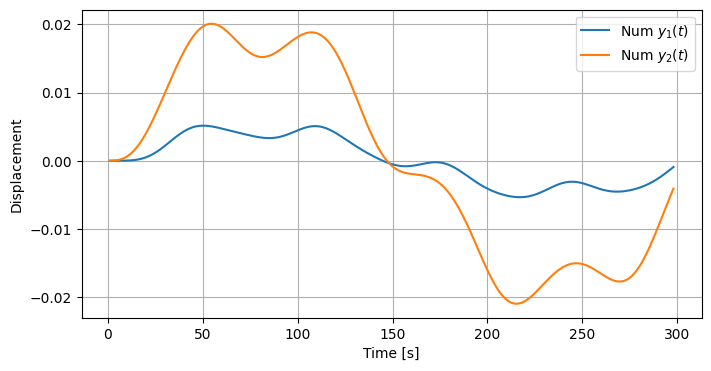

In [59]:
plt.figure(figsize=(8,4))
plt.plot(t[interval], y1[interval], label='Num $y_1(t)$')
plt.plot(t[interval], y2[interval], label='Num $y_2(t)$')
plt.xlabel('Time [s]')
plt.ylabel('Displacement')
plt.legend()
plt.grid(True)
plt.show()

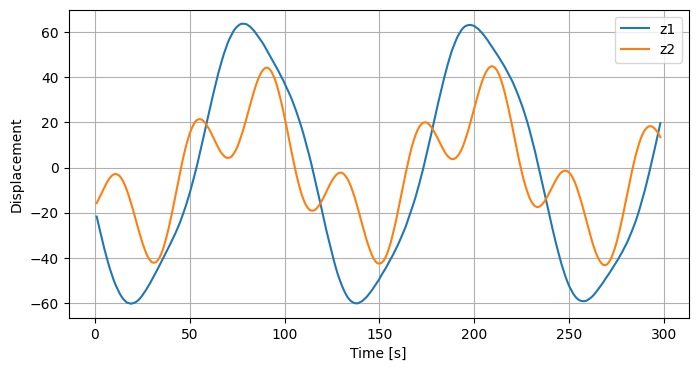

In [63]:
plt.figure(figsize=(8,4))
plt.plot(t[interval], z1_diff[interval], label="z1")
plt.plot(t[interval], z2_diff[interval], label="z2")
plt.xlabel('Time [s]')
plt.ylabel('Displacement')
plt.legend()
plt.grid(True)
plt.show()